In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

from prettytable import PrettyTable

In [52]:
def knn_kfold_validation(neighbours, X_train, y_train, algo='auto'):
    cv_scores=[]
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10)
        cv_scores.append(scores.mean())
        print("K : %d , Score : %f" % (k,scores.mean()))
    return cv_scores

def optimal_k_plot(neighbours, cv_scores):    
    optimal_k = neighbours[cv_scores.index(max(cv_scores))]
    plt.plot(neighbours, cv_scores)
    for xy in zip(neighbours,np.round(cv_scores,2)):
        plt.annotate("('%s',%s)"% xy, xy=xy, textcoords='data')
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('CV_Scores')
    print("CV_SCORES: ",cv_scores)
    return optimal_k

def optimal_knn(optimal_k, X_train, X_test, y_train, y_test, algo='auto'):
    # ============================== KNN with k = optimal_k ===============================================
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm = algo)

    # fitting the model
    knn_optimal.fit(X_train, y_train)

    # predict the response
    pred = knn_optimal.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    
    return pred

def gen_confusion(c_matrix):
    print(sns.heatmap(c_matrix,cmap="viridis",fmt='g', annot=True))
    
def gen_tfidf_w2v(model,list_of_sent,w2v_model,dictionary):
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [4]:
# Reading processed dataset
data = pd.read_csv('final_data.csv')
data.dropna(inplace=True)

In [6]:
data.shape

(364156, 11)

In [7]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [5]:
data.sort_values(by='Time',ascending=True, inplace=True)

In [6]:
data.reset_index(drop=True, inplace=True)

In [10]:
sampled_data = data.loc[:99999]

In [11]:
sampled_data.shape

(100000, 11)

In [12]:
sampled_data['Score'].replace('positive','1',inplace=True)
sampled_data['Score'].replace('negative','0', inplace=True)

C:\Users\prabh\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
sampled_data['Score'].value_counts()

1    87730
0    12270
Name: Score, dtype: int64

In [14]:
X = sampled_data['CleanedText']
y = sampled_data['Score']

In [15]:
X_train = X[:67000]
y_train = y[:67000]
X_test = X[67000:]
y_test = y[67000:]

In [75]:
table = PrettyTable()

# BOW

In [14]:
count_vect = CountVectorizer()

In [15]:
count_vect.fit(X_train.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [16]:
train_counts = count_vect.transform(X_train.values)

In [17]:
print(type(train_counts))
print(train_counts.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(67000, 30764)


In [18]:
test_counts = count_vect.transform(X_test.values)

In [19]:
knn= KNeighborsClassifier(n_neighbors=5)
knn.fit(train_counts,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
pred = knn.predict(test_counts)

In [60]:
accuracy_score(y_test,pred)

0.8811212121212121

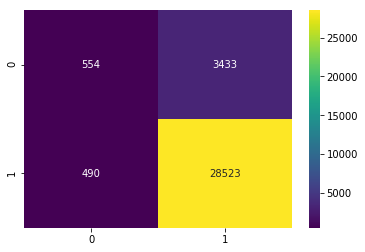

In [68]:
gen_confusion(confusion_matrix(y_test,pred))

In [39]:
neighbours = list(range(3,41,2))

In [21]:
cv_scores = knn_kfold_validation(neighbours, X_train=train_counts,y_train=y_train)

K : 3 , Score : 0.874164
K : 5 , Score : 0.879612
K : 7 , Score : 0.881269
K : 9 , Score : 0.881328
K : 11 , Score : 0.881104
K : 13 , Score : 0.881164
K : 15 , Score : 0.880985
K : 17 , Score : 0.880791
K : 19 , Score : 0.880537
K : 21 , Score : 0.880254
K : 23 , Score : 0.879910
K : 25 , Score : 0.880015
K : 27 , Score : 0.879910
K : 29 , Score : 0.879940
K : 31 , Score : 0.879836
K : 33 , Score : 0.879657
K : 35 , Score : 0.879642
K : 37 , Score : 0.879507
K : 39 , Score : 0.879298


CV_SCORES:  [0.8741639992053504, 0.8796119208639357, 0.8812685994364321, 0.8813283454789982, 0.881104464881983, 0.8811641530098445, 0.880985028479566, 0.8807910186728416, 0.8805372895555632, 0.8802536918713397, 0.8799104506086188, 0.8800149438158954, 0.8799104350146127, 0.8799403058088929, 0.8798358036922755, 0.879656703669999, 0.8796417649268686, 0.8795074343413247, 0.8792984857967896]


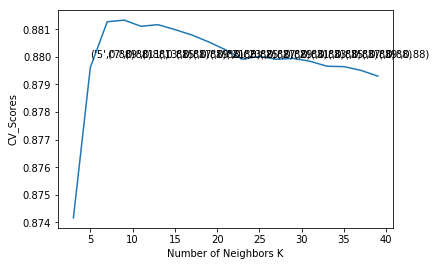

In [23]:
op_k = optimal_k_plot(neighbours, cv_scores)

In [27]:
pred = optimal_knn(op_k, train_counts, test_counts, y_train, y_test)


The accuracy of the knn classifier for k = 9 is 88.384848%


In [29]:
conf_matrix = confusion_matrix(y_test,pred)

AxesSubplot(0.125,0.125;0.62x0.755)


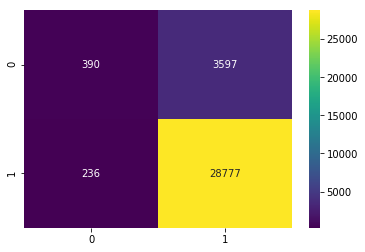

In [30]:
from prettytable

In [ ]:
# Model (Algorithm) HyperParameter(k) TrainError TestError

In [81]:
table = PrettyTable()
table.field_names = ["Model(Algorithm)", "Technique", "HyperParameter(k)", "TrainAccuracy", "TestAccuracy"]
table.add_row(['KNN(Brute Force)', 'Bag Of Words','k = 9', "88.13%", "88.34%"])
print(table)

+------------------+--------------+-------------------+---------------+--------------+
| Model(Algorithm) |  Technique   | HyperParameter(k) | TrainAccuracy | TestAccuracy |
+------------------+--------------+-------------------+---------------+--------------+
| KNN(Brute Force) | Bag Of Words |       k = 9       |     88.13%    |    88.34%    |
+------------------+--------------+-------------------+---------------+--------------+


# Tfidf

In [16]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

In [17]:
tf_idf_vect.fit(X_train.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [27]:
train_counts = tf_idf_vect.transform(X_train.values)

In [28]:
test_counts = tf_idf_vect.transform(X_test.values)

In [29]:
cv_scores = knn_kfold_validation(neighbours, X_train=train_counts,y_train=y_train)

K : 3 , Score : 0.880552
K : 5 , Score : 0.885866
K : 7 , Score : 0.887164
K : 9 , Score : 0.887418
K : 11 , Score : 0.886567
K : 13 , Score : 0.886612
K : 15 , Score : 0.886597
K : 17 , Score : 0.886060
K : 19 , Score : 0.885612
K : 21 , Score : 0.885493
K : 23 , Score : 0.885105
K : 25 , Score : 0.885045
K : 27 , Score : 0.884537
K : 29 , Score : 0.884119
K : 31 , Score : 0.884224
K : 33 , Score : 0.884105
K : 35 , Score : 0.883985
K : 37 , Score : 0.883746
K : 39 , Score : 0.883567


CV_SCORES:  [0.8805522862167232, 0.8858657124483406, 0.8871642444243489, 0.8874179624089411, 0.8865672094522941, 0.8866119788850366, 0.8865970535125672, 0.8860597400717518, 0.8856119833270724, 0.8854925892493437, 0.8851045406831972, 0.8850448547800113, 0.8845373987687999, 0.8841194749523726, 0.8842239614756486, 0.8841045495792385, 0.8839851465941637, 0.8837463383940195, 0.8835672227757417]


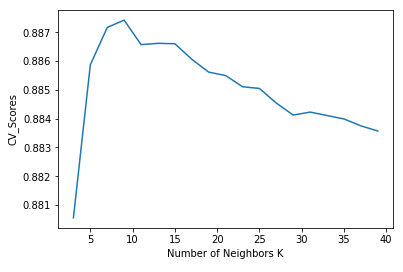

In [30]:
op_k = optimal_k_plot(neighbours, cv_scores)

In [32]:
pred = optimal_knn(op_k, train_counts, test_counts, y_train, y_test,algo='brute')


The accuracy of the knn classifier for k = 9 is 89.054545%


In [36]:
conf_matrix = confusion_matrix(y_test, pred)

AxesSubplot(0.125,0.125;0.62x0.755)


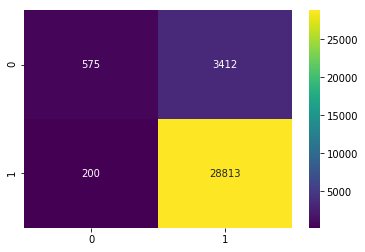

In [37]:
gen_confusion(conf_matrix)

In [82]:
table = PrettyTable()
table.field_names = ["Model(Algorithm)", "Technique", "HyperParameter(k)", "TrainAccuracy", "TestAccuracy"]
table.add_row(['KNN(Brute Force)', 'Tfidf','k = 9', "88.7%", "89%"])
print(table)

+------------------+-----------+-------------------+---------------+--------------+
| Model(Algorithm) | Technique | HyperParameter(k) | TrainAccuracy | TestAccuracy |
+------------------+-----------+-------------------+---------------+--------------+
| KNN(Brute Force) |   Tfidf   |       k = 9       |     88.7%     |     89%      |
+------------------+-----------+-------------------+---------------+--------------+


# Average Word2Vec

In [23]:
list_of_sent = []
for sentence in X_train:
  try:
    list_of_sent.append(sentence.split())
  except:
    print(sentence)
len(list_of_sent)

67000

In [24]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [25]:
w2v_words = list(w2v_model.wv.vocab)

In [26]:
len(w2v_words)

10452

In [64]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

67000
50


In [68]:
cv_scores = knn_kfold_validation(neighbours, sent_vectors, y_train)

K : 3 , Score : 0.888059
K : 5 , Score : 0.894134
K : 7 , Score : 0.897060
K : 9 , Score : 0.898463
K : 11 , Score : 0.899134
K : 13 , Score : 0.899433
K : 15 , Score : 0.899283
K : 17 , Score : 0.899448
K : 19 , Score : 0.899045
K : 21 , Score : 0.899343
K : 23 , Score : 0.899134
K : 25 , Score : 0.898851
K : 27 , Score : 0.898851
K : 29 , Score : 0.898463
K : 31 , Score : 0.898089
K : 33 , Score : 0.897851
K : 35 , Score : 0.897985
K : 37 , Score : 0.897880
K : 39 , Score : 0.897895


CV_SCORES:  [0.8880594928229157, 0.8941341576317529, 0.8970595263453245, 0.8984625092152253, 0.8991342200729454, 0.8994327409062928, 0.8992834247969295, 0.899447588308731, 0.8990445586774255, 0.8993430906487789, 0.8991341666109159, 0.8988506045633905, 0.8988506045613958, 0.8984625359452425, 0.8980893793342227, 0.8978505778207388, 0.8979849039516126, 0.8978804486150193, 0.8978953294374599]


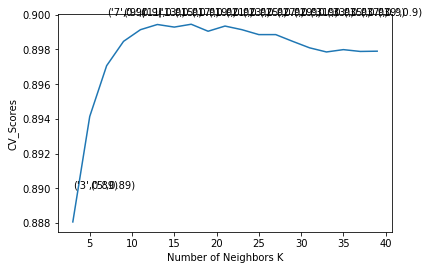

In [69]:
op_k = optimal_k_plot(neighbours, cv_scores)

In [70]:
op_k

17

In [84]:
test_list_of_sent = []
for sentence in X_test:
  try:
    test_list_of_sent.append(sentence.split())
  except:
    print(sentence)
print(len(test_list_of_sent))
# average Word2Vec
# compute average word2vec for each review.
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in test_list_of_sent: # for each review/sentence
    test_sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            test_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        test_sent_vec /= cnt_words
    test_sent_vectors.append(test_sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

33000
33000
50


In [85]:
pred = optimal_knn(17, sent_vectors, test_sent_vectors, y_train, y_test,algo='brute')


The accuracy of the knn classifier for k = 17 is 88.563636%


In [86]:
conf_matrix = confusion_matrix(y_test, pred)

AxesSubplot(0.125,0.125;0.62x0.755)


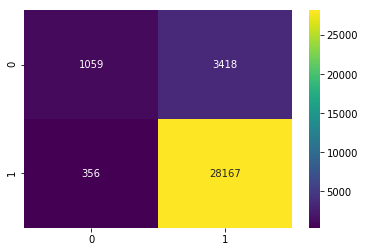

In [87]:
gen_confusion(conf_matrix)

In [83]:
table = PrettyTable()
table.field_names = ["Model(Algorithm)", "Technique", "HyperParameter(k)", "TrainAccuracy", "TestAccuracy"]
table.add_row(['KNN(Brute Force)', 'Avg Word2Vec','k = 17', "89.9%", "88.56%"])
print(table)

+------------------+--------------+-------------------+---------------+--------------+
| Model(Algorithm) |  Technique   | HyperParameter(k) | TrainAccuracy | TestAccuracy |
+------------------+--------------+-------------------+---------------+--------------+
| KNN(Brute Force) | Avg Word2Vec |       k = 17      |     89.9%     |    88.56%    |
+------------------+--------------+-------------------+---------------+--------------+


In [16]:
list_of_sent = []
for sentence in X_train:
  try:
    list_of_sent.append(sentence.split())
  except:
    print(sentence)
len(list_of_sent)

67000

In [20]:
tf_idf_vect = TfidfVectorizer()

In [21]:
tf_idf_vect.fit(X_train.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [26]:
from tqdm import tqdm

In [27]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [28]:
w2v_words = list(w2v_model.wv.vocab)

In [47]:
X_train = gen_tfidf_w2v(tf_idf_vect,list_of_sent,w2v_model,dictionary)

100%|███████████████████████████████████████████████████████████████████████████| 67000/67000 [01:17<00:00, 865.91it/s]


In [40]:
cv_scores = knn_kfold_validation(neighbours, X_train,y_train=y_train)

K : 3 , Score : 0.880433
K : 5 , Score : 0.888880
K : 7 , Score : 0.892149
K : 9 , Score : 0.893716
K : 11 , Score : 0.894478
K : 13 , Score : 0.894746
K : 15 , Score : 0.895269
K : 17 , Score : 0.894806
K : 19 , Score : 0.894970
K : 21 , Score : 0.894836
K : 23 , Score : 0.895030
K : 25 , Score : 0.894836
K : 27 , Score : 0.895045
K : 29 , Score : 0.894851
K : 31 , Score : 0.894552
K : 33 , Score : 0.894582
K : 35 , Score : 0.894627
K : 37 , Score : 0.894194
K : 39 , Score : 0.893836


CV_SCORES:  [0.8804326070015209, 0.8888804529420142, 0.8921491765383358, 0.8937163184647025, 0.8944775280965394, 0.8947461335822527, 0.895268510511263, 0.8948057927467767, 0.8949699963572613, 0.8948356657677273, 0.8950296956231284, 0.8948356613177116, 0.8950446455022696, 0.8948505978275222, 0.8945521015001816, 0.8945819166031024, 0.8946266927231703, 0.8941938658082907, 0.8938356568510718]


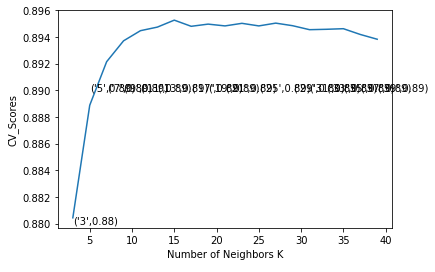

In [41]:
op_k = optimal_k_plot(neighbours, cv_scores)

In [42]:
op_k

15

In [43]:
test_list_of_sent = []
for sentence in X_test:
  try:
    test_list_of_sent.append(sentence.split())
  except:
    print(sentence)

In [49]:
X_test = gen_tfidf_w2v(tf_idf_vect,test_list_of_sent,w2v_model,dictionary)

100%|███████████████████████████████████████████████████████████████████████████| 33000/33000 [00:42<00:00, 776.38it/s]


In [50]:
pred = optimal_knn(15,X_train,X_test,y_train,y_test,algo='brute')


The accuracy of the knn classifier for k = 15 is 87.939394%


In [51]:
conf_matrix = confusion_matrix(y_test, pred)

AxesSubplot(0.125,0.125;0.62x0.755)


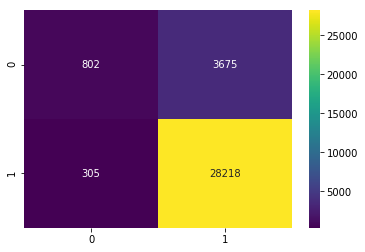

In [52]:
gen_confusion(conf_matrix)

In [84]:
table = PrettyTable()
table.field_names = ["Model(Algorithm)", "Technique", "HyperParameter(k)", "TrainAccuracy", "TestAccuracy"]
table.add_row(['KNN(Brute Force)', 'Avg Word2Vec','k = 15', "89.5%", "87.9%"])
print(table)

+------------------+--------------+-------------------+---------------+--------------+
| Model(Algorithm) |  Technique   | HyperParameter(k) | TrainAccuracy | TestAccuracy |
+------------------+--------------+-------------------+---------------+--------------+
| KNN(Brute Force) | Avg Word2Vec |       k = 15      |     89.5%     |    87.9%     |
+------------------+--------------+-------------------+---------------+--------------+


In [53]:
# kd-tree


In [7]:
data.sort_values(by='Time',ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
sampled_data = data.loc[:9999]

In [9]:
sampled_data.shape

(10000, 11)

In [10]:
sampled_data['Score'].replace('positive','1',inplace=True)
sampled_data['Score'].replace('negative','0', inplace=True)

C:\Users\prabh\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
X = sampled_data['CleanedText']
y = sampled_data['Score']

In [12]:
X_train = X[:6700]
y_train = y[:6700]
X_test = X[6700:]
y_test = y[6700:]

In [20]:
#BOW

In [13]:
count_vect = CountVectorizer()

In [14]:
count_vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
bow_X_train = count_vect.transform(X_train)

In [16]:
bow_X_test = count_vect.transform(X_test)

In [17]:
neighbours = list(range(3,41,2))

In [19]:
pred = optimal_knn(9, bow_X_train.toarray(),bow_X_test.toarray(),y_train, y_test, algo='kd_tree')


The accuracy of the knn classifier for k = 9 is 89.515152%


AxesSubplot(0.125,0.125;0.62x0.755)


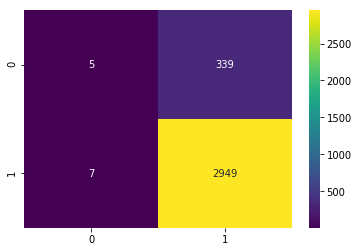

In [23]:
conf_matrix = confusion_matrix(y_test, pred)
gen_confusion(conf_matrix)

In [85]:
table = PrettyTable()
table.field_names = ["Model(Algorithm)", "Technique", "HyperParameter(k)", "TrainAccuracy", "TestAccuracy"]
table.add_row(['KNN(Kd_tree)', 'Bag Of Words','k = 9', "88.1%", "88.51%"])
print(table)

+------------------+--------------+-------------------+---------------+--------------+
| Model(Algorithm) |  Technique   | HyperParameter(k) | TrainAccuracy | TestAccuracy |
+------------------+--------------+-------------------+---------------+--------------+
|   KNN(Kd_tree)   | Bag Of Words |       k = 9       |     88.1%     |    88.51%    |
+------------------+--------------+-------------------+---------------+--------------+


# Tf_idf Kd_tree 

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

In [25]:
tf_idf_vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
tf_idf_train = tf_idf_vect.transform(X_train)

In [29]:
tf_idf_test = tf_idf_vect.transform(X_test)

In [32]:
pred = optimal_knn(9, tf_idf_train.toarray(), tf_idf_test.toarray(), y_train, y_test,algo='kd_tree')


The accuracy of the knn classifier for k = 9 is 90.666667%


In [33]:
conf_matrix = confusion_matrix(y_test, pred)

AxesSubplot(0.125,0.125;0.62x0.755)


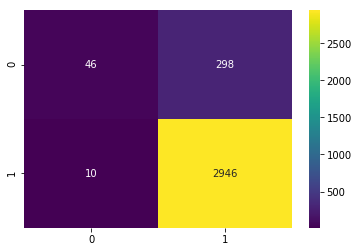

In [35]:
gen_confusion(conf_matrix)

# Kd_tree Average W2V

In [ ]:
#Average W2V

In [36]:
list_of_sent = []
for sentence in X_train:
  try:
    list_of_sent.append(sentence.split())
  except:
    print(sentence)
len(list_of_sent)

6700

In [38]:
test_list_of_sent = []
for sentence in X_test:
  try:
    test_list_of_sent.append(sentence.split())
  except:
    print(sentence)
print(len(test_list_of_sent))

3300


In [39]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [41]:
w2v_words = list(w2v_model.wv.vocab)

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

6700
50


In [43]:
# average Word2Vec
# compute average word2vec for each review.
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in test_list_of_sent: # for each review/sentence
    test_sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            test_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        test_sent_vec /= cnt_words
    test_sent_vectors.append(test_sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

3300
50


In [45]:
pred = optimal_knn(17, sent_vectors, test_sent_vectors, y_train, y_test,algo='kd_tree')


The accuracy of the knn classifier for k = 17 is 89.515152%


In [48]:
conf_mat = confusion_matrix(y_test,pred)

AxesSubplot(0.125,0.125;0.62x0.755)


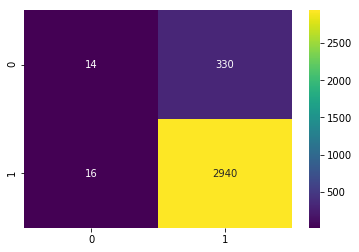

In [49]:
gen_confusion(conf_mat)

# Kd_tree Tfidf W2V

In [50]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [55]:
X_train = gen_tfidf_w2v(tf_idf_vect,list_of_sent,w2v_model,dictionary)

100%|█████████████████████████████████████████████████████████████████████████████| 6700/6700 [00:13<00:00, 494.58it/s]


In [56]:
X_test = gen_tfidf_w2v(tf_idf_vect,test_list_of_sent,w2v_model,dictionary)

100%|█████████████████████████████████████████████████████████████████████████████| 3300/3300 [00:04<00:00, 715.28it/s]


In [57]:
pred = optimal_knn(15,X_train,X_test,y_train,y_test,algo='kd_tree')


The accuracy of the knn classifier for k = 15 is 89.515152%


In [58]:
conf_mat = confusion_matrix(y_test,pred)

AxesSubplot(0.125,0.125;0.62x0.755)


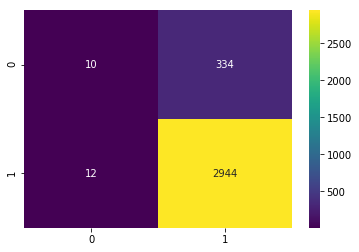

In [59]:
gen_confusion(conf_mat)